# Matching and Subclassification

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import math
import random

# 5.1.3 Subclassification Exercise

In [16]:
# titanic

url = 'https://github.com/scunning1975/mixtape/raw/master/titanic.dta'

df = pd.read_stata(url)

# calculate SDO

df['is_first_class'] = df['class'] == '1st class'
df['survived'] = df.survived == 'yes'

grouped_mean = df.groupby("is_first_class").survived.mean()
SDO = grouped_mean[True] - grouped_mean[False]
print(SDO)

0.3538264720354272


In [34]:
# titanic_subclassification

# stratify into four groups

df['group'] = None

for age in set(df.age):
    is_age = df.age == age
    
    for sex in set(df.sex):
        is_sex = df.sex == sex
        
        df.loc[is_age & is_sex, 'group'] = age + "-" + sex

Text(0, 0.5, 'Age & Sex Group')

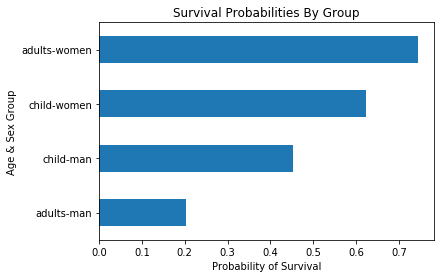

In [37]:
df.groupby("group").survived.mean().sort_values().plot.barh()
plt.title("Survival Probabilities By Group")
plt.xlabel('Probability of Survival')
plt.ylabel("Age & Sex Group")

In [62]:
non_first_class = df[df.is_first_class == False]

weights = non_first_class.groupby('group').survived.count() / len(non_first_class)

# Weighted ATE

wate = 0

for group in weights.index:
    
    temp = df[df.group == group]
    grouped_mean = temp.groupby('is_first_class').survived.mean()
    
    sdo = grouped_mean[True] - grouped_mean[False]
    
    wate += weights[group]*sdo
    
print('Weighted Average Treatment Effect', round(wate,4))

Weighted Average Treatment Effect 0.1888
